Everybody loves profit, everyone loves a low price, how do we reconcile the two?

"Supply chain is the practice of predicting the future and bending it to your will." - Ronaldo

	In every marketplace, businesses and consumers make decisions about price, quantities and timing of purchases and sales in a melee of rapid-fire decision making and half-baked assumptions. Rarely, do any decisions not involve some consideration of predicting the future: "What will the price be in a week? If so, should I buy now?" or "What price do I need to set in order to sell all of my inventory?" are common questions, and the answers to them are not cheap. Predicting the future is hard, predicting it accurately is even more so. However, many decisions need to be based off of events that have not yet happened, which creates quite a conundrum. Especially, when business is concerned, the difference between accurate and not can be billions of dollars.

	Predictive analytics is the field of taking the data from the past, and attempting to predict behavior in the future, or under new conditions. It is the methods used by a data analyst to pull back the curtains of the future and peek through at what might be expected.

	For our project, we are answering the question "What price should I charge in order to get the best return?"  Generally, in the short term and the long term, these answers are different, and our methods lend themselves well to aiding in both areas. 

	The price at which all of the inventory is sold, but no one who would have bought a product goes without is called the market clearing price. It is generally considered to be the intersection of the supply and demand curves. (For a description of what these mean, we refer you to an introductory book on economics.) In theory, the optimal price to sell goods is this price, the price at which the last item is purchased by the last customer who wanted to buy. However, finding this price requires knowing both the supply and demand curves, which is a major difficulty.

	Supply and demand curves are abstractly representative of the workings of a market, however, there is no parametric equation for the curves for specific businesses, handed out in business school. Indeed, guessing at these curves, as they determine the results of many actions a business might take, is what consumes so much time in making a market forecast. If a business owner knows the shape of the demand curve, they can easily calculate exactly what price to charge in order to sell all of their inventory or fill all their hotel rooms.

	Supply curves, though not a trivial task, are going to be easier for a business owner to predict, since they know the cost to expand their enterprise, the price at which additional workers are hired, and the salaries and productivity of their individual workers, and have access to a great deal of data that allows them to manage their business. Demand curves are much harder to understand and predict, since the apparatus of decision making is much more outside of the owner's control, a semi-chaotic system containing a myriad of systems and complex interactions all simplifying down to individual decisions of how much to buy.

	In order to predict demand curves, we use a Poisson process.  However, since the average rate may change over time and vary in response to a host of factors, we use a non-homogeneous Poisson process, one where lambda (the descriptor of the average rate at which events happen) changes in response to time, and other variables. 

Data Collection
	Data on arrival and purchase times, prices, etc is highly proprietary, and thus can be very difficult to come across. Because of this, academia has developed standards for generating data, to be used in research on predicting demand curves and related situations. Using these standard functions, we have generated a significant quantity of data for testing, training, and refining our model.

***Modelling arrival times using Nonhomogeneous Poisson Processes***

This document explains the concept and capabilities we have to analyze time series data for transactions. Applications to a parking model are given, but an entire parking model is not derived.

A (Homogeneous) Poisson Process assumes that the rate of arrivals (per time unit) is constant and that the time between arrivals is independent of all prior arrivals. 

A Poisson Process has only one parameter lambda, the rate (arrivals per unit of time).

To simulate a Homogeneous Poisson Process over T time units, simply calculate the times between arrivals iteratively by this algorithm:

Simulate Poisson (Nonhomogeneous)
1. input: rate, T (number of hours, days, etc... to simulate at constant rate)
2. current_time <- 0
3. times <- []
4. u = sample_random_float (between 0 and 1)
5. interarrival_time <- -log(u) / rate
6. if interarrival_time + current_time < T then
7.     append (current_time + interarrival_time) to the list times
8.     return to 3
9. return times

The next visualization shows the Poisson probability distribution

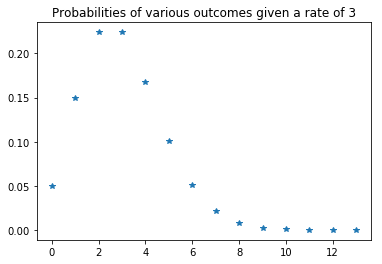

In [1]:
from matplotlib import pyplot as plt
import numpy as np; np.set_printoptions(2)
from scipy.stats import poisson
from scipy.special import factorial

number_of_time_units = 1
rate = 5


# Scale the rate parameter by the length of time
def gen_probabilities_for_outcomes(rate, length_of_time=1., n=10):
    rate *= length_of_time
    res2 = poisson(rate).pmf(np.arange(n))
    res2[res2 <= 0] = 0 # Unforunately -0.0 is a valid floating point number
    return res2

n = 14
rate = 3
test_vector = gen_probabilities_for_outcomes(rate, 1, n)
plt.title("Probabilities of various outcomes given a rate of " + str(rate))
plt.plot(np.arange(n), test_vector, "*")
plt.show()




***Achtung!***
Note that for this distribution the probability with rate 3 the probability that a 3 is observed is only 0.224

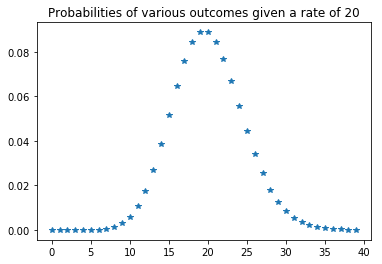

In [2]:
rate = 20
n = 40
test_vector = gen_probabilities_for_outcomes(rate, 1, n)
assert  test_vector.sum() > .99 and np.min(test_vector) >= 0, "Not a probability vector:\n" + str(test_vector) + "\n" + str(test_vector.sum())
plt.title("Probabilities of various outcomes given a rate of " + str(rate))
plt.plot(np.arange(n), test_vector, "*")
plt.show()


Note that the Maximum Likelihood Estimate (MLE) of the rate parameter given some data in a time interval is the number of occurences. We will see that using only one set of data within a time interval is naive

***Modelling Parking Example, a Naive Approach*** 

Suppose that we wish to estimate how frequent customers arrive during different times of a work day to predict future demand. It would be naive to believe that the average rate is constant throughout the day. Assuming that distribution is poisson but not homogeneous lets us divide time intervals into bins and estimate the aggregate rate for those intervals.

We will do this by dividing the work day into 8 time intervals (hours) and count how many arrivals happened within each. Those counts represent our best estimate for the rate function for each hour.

In doing this, this is our first way to overcome the assumption that arrivals occur at the same rate throughout the day.

In [3]:
# Try to model arrivals by estimating each hour separately
discrete_rates = np.array([8,6,4,3,5,7,8,8]) # the rates for each time interval
aggregate_rate = sum(discrete_rates) # the aggregate rate for the work day is 51

# We now simulate a day using those rates
def realize_process(discrete_rates):
    # This just works...
    result = [np.arange(r*10)[np.random.random() < np.cumsum(gen_probabilities_for_outcomes(r, 1, r*10))][0] for r in discrete_rates]
    return np.array(result)
        
print("Notice the varation (in ratios) between the actual counts observed and the expected counts. The ratios are for the hours 9-10, 10-11, 11-12, etc...")

def realize_n_proccesses(discrete_rates, n):
    return np.array([realize_process(discrete_rates) for _ in range(n)])

n, k = 5, 1
realizations = realize_n_proccesses(discrete_rates,n)
for row in realizations:
    print("Simulation", k, row/discrete_rates); k+=1



Notice the varation (in ratios) between the actual counts observed and the expected counts. The ratios are for the hours 9-10, 10-11, 11-12, etc...
Simulation 1 [ 1.    0.67  1.25  1.67  0.8   0.86  0.75  0.38]
Simulation 2 [ 0.75  1.33  1.25  1.    0.8   2.14  0.88  1.5 ]
Simulation 3 [ 1.    1.17  1.5   0.    1.2   1.    0.75  0.5 ]
Simulation 4 [ 1.    0.83  1.75  0.33  0.6   1.29  0.38  1.12]
Simulation 5 [ 1.12  1.17  0.5   0.33  0.8   0.57  0.88  0.75]


***Relative Errors of these estimates as a percentage***

Rows denote different days, columns denote which time interval the estimate is in.

In [4]:
relative_errors = 100*(realizations - discrete_rates) / discrete_rates # Uses Array Broadcasting unique to numpy
print("Rates from which each realization is drawn: ", discrete_rates)
print(relative_errors)

Rates from which each realization is drawn:  [8 6 4 3 5 7 8 8]
[[   0.    -33.33   25.     66.67  -20.    -14.29  -25.    -62.5 ]
 [ -25.     33.33   25.      0.    -20.    114.29  -12.5    50.  ]
 [   0.     16.67   50.   -100.     20.      0.    -25.    -50.  ]
 [   0.    -16.67   75.    -66.67  -40.     28.57  -62.5    12.5 ]
 [  12.5    16.67  -50.    -66.67  -20.    -42.86  -12.5   -25.  ]]


***Any one of these rows could be the relative error per hour if we only use one day***

Now we will observe that the relative errors go down as the rate goes up. 

In [5]:
# Use a poisson process with 20 times the rate parameter
discrete_rates2 = 20*discrete_rates

realizations2 = realize_n_proccesses(discrete_rates2,n)

standard_deviations_away2 = (realizations2 - discrete_rates2) / np.sqrt(discrete_rates2) # Uses Array Broadcasting unique to numpy
relative_errors2 = 100*(realizations2 - discrete_rates2) / discrete_rates2 # Uses Array Broadcasting unique to numpy
print("New rates: " + str(discrete_rates2))
print("Standard Deviations away from the true value:",
      "\nNote that this does not imply that it's normally distributed\n",standard_deviations_away2)
print("\nRelative error of each estimate as a percentage:\n", relative_errors2)


New rates: [160 120  80  60 100 140 160 160]
Standard Deviations away from the true value: 
Note that this does not imply that it's normally distributed
 [[ 0.95  1.73  1.57  0.13 -0.9  -0.34  1.34  0.16]
 [ 0.4   0.37 -0.11  2.58 -0.5  -0.68  2.85  1.34]
 [-1.5  -0.37 -0.78 -0.13  0.7   0.   -1.03  0.71]
 [ 1.11  0.73  0.78 -1.16  1.3   0.   -0.08  0.4 ]
 [ 1.34 -1.1   0.78  0.13 -0.5  -1.77 -0.55 -1.11]]

Relative error of each estimate as a percentage:
 [[  7.5   15.83  17.5    1.67  -9.    -2.86  10.62   1.25]
 [  3.12   3.33  -1.25  33.33  -5.    -5.71  22.5   10.62]
 [-11.88  -3.33  -8.75  -1.67   7.     0.    -8.12   5.62]
 [  8.75   6.67   8.75 -15.    13.     0.    -0.62   3.12]
 [ 10.62 -10.     8.75   1.67  -5.   -15.    -4.38  -8.75]]


***Increased Accuracy Observed with increasing rates, length of time intervals***

As you can see here, as the rate was increased by a factor of 20, the relative error decreased significantly (can be expected to be the inverse square of 20). Equivalently, when we extend the length of the time intervals, we observe the same decrease of relative error.

There is a trade off between the size of time intervals and the accuracy of your estimates. If you make the size of the time intervals larger, the relative error goes down, but there is less information to exploit for a dynamic pricing engine. Research suggests that when using discreet estimates for the rate function the bin width should decrease with the amount of data collected.

***Estimating a interval rates by overlapping data***

Only using one day is too simplistic, and with small amounts of data the ideal width of time intervals would be the entire day.

To overcome this, we can create estimates for the rate function by overlapping data from different days that are assumed to be drawn from the same rate distribution.


Nonhomogeneous denotes that our Poisson process has a rate that varies over time. For a given continuous rate function, there is still a well defined average rate for a time interval, so our analysis here still works.



***Application: ***the larger the parking lot the more certainty we can give our estimates.

***Stacking multiple days***

If we stack multiple simulations on top of one another we get a higher accuracy estimate of small time intervals.

The way we do this is to add up the arrivals in each interval across the number of days and then divide by the number of days.

Here we show that by using stacking 10 days worth of simulated data, we can ***expect the same accuracy (small distribution of relative errors)*** as when multiplying the rates by 10.


In [6]:
def get_average_rate_n_simulations(discrete_rates, n_simulations):
    result = np.sum(realize_n_proccesses(discrete_rates,n_simulations), axis=0) / n_simulations
    return result

estimate = get_average_rate_n_simulations(discrete_rates, 20)
print("Notice that each time we stack 20 different simulations we get a much more accurate estimations for each hour")
print("average of 20 simulated work days", estimate)
print("These are are to estimate", 1.*discrete_rates)

relative_errors3 = 100*(estimate-discrete_rates)/discrete_rates
print("\nRelative error by hour of day:", relative_errors3)


print("\nAverage magnitude of the relative errors")
print("  One sample at original rate function:", np.abs(relative_errors).mean())
print("  Multiplying the rate function by 20:",np.abs(relative_errors2).mean())
print("  Stacking 20 samples of the same rate function:", np.abs(relative_errors3).mean())


Notice that each time we stack 20 different simulations we get a much more accurate estimations for each hour
average of 20 simulated work days [ 8.65  6.65  4.25  3.55  5.05  7.6   9.4   8.4 ]
These are are to estimate [ 8.  6.  4.  3.  5.  7.  8.  8.]

Relative error by hour of day: [  8.13  10.83   6.25  18.33   1.     8.57  17.5    5.  ]

Average magnitude of the relative errors
  One sample at original rate function: 33.4166666667
  Multiplying the rate function by 20: 7.93928571429
  Stacking 20 samples of the same rate function: 9.45163690476


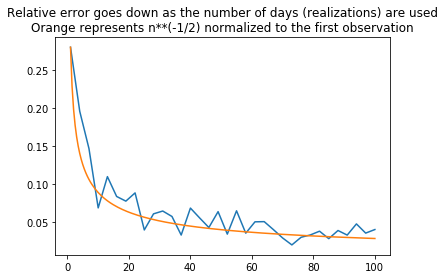

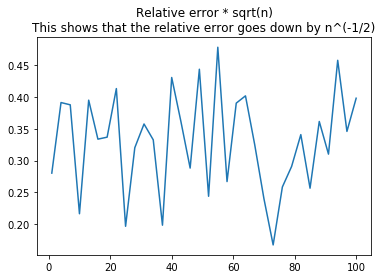

In [7]:
def get_average_relative_error_n_simulations(discrete_rates, n_simulations):
    result = (get_average_rate_n_simulations(discrete_rates, n_simulations)-discrete_rates)/discrete_rates
    return np.abs(result).mean()

plt.title("Relative error goes down as the number of days (realizations) are used\n" + \
          "Orange represents n**(-1/2) normalized to the first observation")

x = np.arange(1,103,3)
y = list(map(lambda x_:get_average_relative_error_n_simulations(discrete_rates, x_), x))
plt.plot(x, y)

x2 = np.linspace(1,100,200)
y2 = y[0]/np.sqrt(x2)
plt.plot(x2,y2)

plt.show()

plt.title("Relative error * sqrt(n)\nThis shows that the relative error goes down by n^(-1/2)")

y = y * np.sqrt(x)
plt.plot(x, y)

plt.show()
    

***Making assumptions about parking arrival times***

We might assume that the average demand between week days (between Monday and Tuesday) can be usually expected to be similar. This would allow us to stack data from different days and get a more accurate measurement of the average rate.

We might also exclude outliers from this average estimation.


***Detecting periods of increased demand***

We now have a discrete estimate for the rate function in time intervals and can use statistical inference to detect the probability that it is a period of increased demand or whether it just happened by statistical chance.

This is a central problem of statistical inferrence, how to quantitatively measure our certainty whether new observations and their deviations from expected values come from the same distribution or if the distribution has changed.

In real life the frequency of arrival times will change over time.

Overcoming this limitation
1. We can constantly recompute the rate estimates using only data that happened in the last few weeks. This is the same tradeoff of how large of time intervals to use, less weeks introduces more random variations. In this case using less overlapping weeks will follow increasing or decreasing trends faster.

***Optimal Pricing through deriving log-linear (monopolistic) demand from estimated rate functions***

A common demand function used in research to model monopolistic demand is a two-parameter log-linear model d(x) = e^(a - b*x)), where b is nonnegative.

This model has the convenient property that for unlimited inventory the revenue is maximized (x multiplied by d(x) where x is the price) when x = 1 / b. It also holds that the price where the revenue function x multiplied by d(x) is maximized is where the price elasticity of demand goes from inelastic to elastic.

Since inventory is always limited this is the lowest an optimal price can be set. This result is academic and may be overruled by other constraints observed in practice (people avoiding firms that aggressively use dynamic pricing) or existing marketing strategies.

Other single variable models include linear (2 parameter), quadratic (3 parameter), log-quadratic (3 parameter, also known as an exponential polynomial since it is the quadratic model exponentiated by e). Note that the model only needs to be valid between the min and max price.

When the monopolistic assumption is relaxed, other models must estimate the demand including the prices of other firms.

***Application 1: (Naive, replicatable) way of finding minimum optimal price of a Monopolistic Parking Firm***

This algorithm will converge with more and more data to the optimal price if the assumptions hold. There are many improvements, and this does not represent machine learning or AI, but it does show one way to use average (Poisson) rates within time intervals in conjunction with a log-linear demand model.

Assumptions
1. the average rate (distribution generating the data) of demand stays constant within a time interval
2. The demand does not vary in between days to overlap, only by time period and price.
3. There are no marginal costs

Method
1. There are 8 time periods (9-10, ... 16-17)
2. Measure average rates of demand for each interval at the base (possibly lowest) price.
3. Then given several higher prices, measure average rate of demand for each of them by time interval.
4. Now for a given time interval, you have average quantity demanded per price
5. Use logarithmic least squares to fit our log-linear model, i.e. fit (p0, log(q0)), ... (pn, log(qn)) to a linear model
6. Parameter estimates are a_, b_
6. Check the mean squared error of each of the eight models, ensure that the errors are small for each. (Statistician needed to do this rigorously)
7. If the mean squared errors are distributed erratically or are poor estimates of demand don't use.
8. If it fits well, we have that for each time period, b in our model is -b_ from the log-linear estimate.
9. For each time period the lowest optimal price for each time period is then 1 / b

***Using discrete estimates for arrival times to predict revenue***

So far we have divided our nonhomogeneous poisson process into time intervals and estimated the rate for those intervals. This has many applications, since the rate of an hour is equal to the quantity demanded for that time period. 


**Continuous Estimates of the Rate Function**

Using discrete estimates of the rate function at different prices, we have made a way to estimate a log-linear demand curve and find a minimum optimal price.

With increasing sizes of datasets, increased accuracy is possible at more finely spaced intervals. We can then fit that data to parameterized demand functions by finding the parameter values that minimize a metric such as mean squared error.

Some methods in the literature require a differentiable representation of the demand function. Parameterized models (linear, quadratic log-linear, log-quadratic) can be very good at interpolating between points, even in the absence of data between them.

Another method of creating a smooth representation of the demand function is to use kernel functions to smooth over the various arrival times.

I couldn't find an implementation of any time series (poisson rate) smoothing in python, so I wrote my own in stats/kernel_estimators.py.

The algorithm slows down significantly with datasets with more than 2000 points, but demonstrates the capability to make smooth demand function estimates independent of parameterized models.


***Technical Summary of ***
